# Mosquito Segmentation Tutorial

This tutorial demonstrates how to use the CulicidaeLab library to perform mosquito segmentation on images. We'll cover:

1. Setting up the segmentation model
2. Loading and preprocessing images
3. Running segmentation
4. Visualizing results

First, let's import the necessary libraries:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from culicidaelab import MosquitoSegmenter
from culicidaelab.detector import MosquitoDetector
from culicidaelab.settings import Settings

c:\Users\lenova\CascadeProjects\culicidaelab\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initialize Settings and Segmenter

First, we'll initialize our settings and create a MosquitoSegmenter instance:

In [2]:
# Initialize settings
settings = Settings()

# Get model weights path and config
model_path = settings.get_model_weights("segmentation")
config = settings.model_weights_manager.config["models"]["segmentation"]

# Initialize segmenter
segmenter = MosquitoSegmenter(model_path=model_path, config=config)

## 2. Load and Preprocess Image

Now let's load a test image:

In [3]:
# Get model weights path
detector_weights_path = settings.get_model_weights("detection")

# Get model config from settings
detector_model_config = settings.model_weights_manager.config["models"]["detection"]

# Initialize detector with correct parameters
detector = MosquitoDetector(
    model_path=detector_weights_path,
    config={"confidence_threshold": detector_model_config.get("params", {}).get("conf_thres", 0.25)},
)
# Load test image
image_path = "640px-Aedes_aegypti.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run detection
detections = detector.predict(image)


0: 448x640 1 aegypti, 221.1ms
Speed: 7.1ms preprocess, 221.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


## 3. Run Segmentation

Now we can run the segmentation model on our image:

In [4]:
mask = segmenter.predict(image)

## 4. Visualize Results

Finally, let's visualize the segmentation results overlaid on the original image:

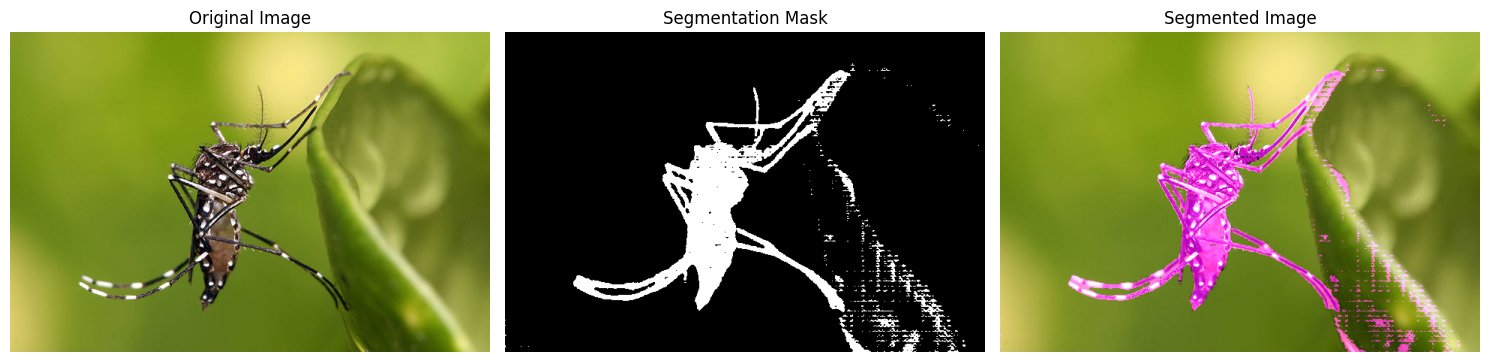

In [5]:
# Visualize segmentation results
segmented_image = segmenter.visualize(image, mask)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.title("Segmentation Mask")

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.axis("off")
plt.title("Segmented Image")

plt.tight_layout()
plt.show()

## Segmentation Using Detection Results

The segmenter can also use detection results to improve segmentation accuracy. Here's how to combine detection and segmentation:


0: 448x640 1 aegypti, 212.8ms
Speed: 7.6ms preprocess, 212.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

Detection Results:
Mosquito 1: Confidence = 0.83, Box = (x=299.6, y=227.9, w=359.2, h=365.3)


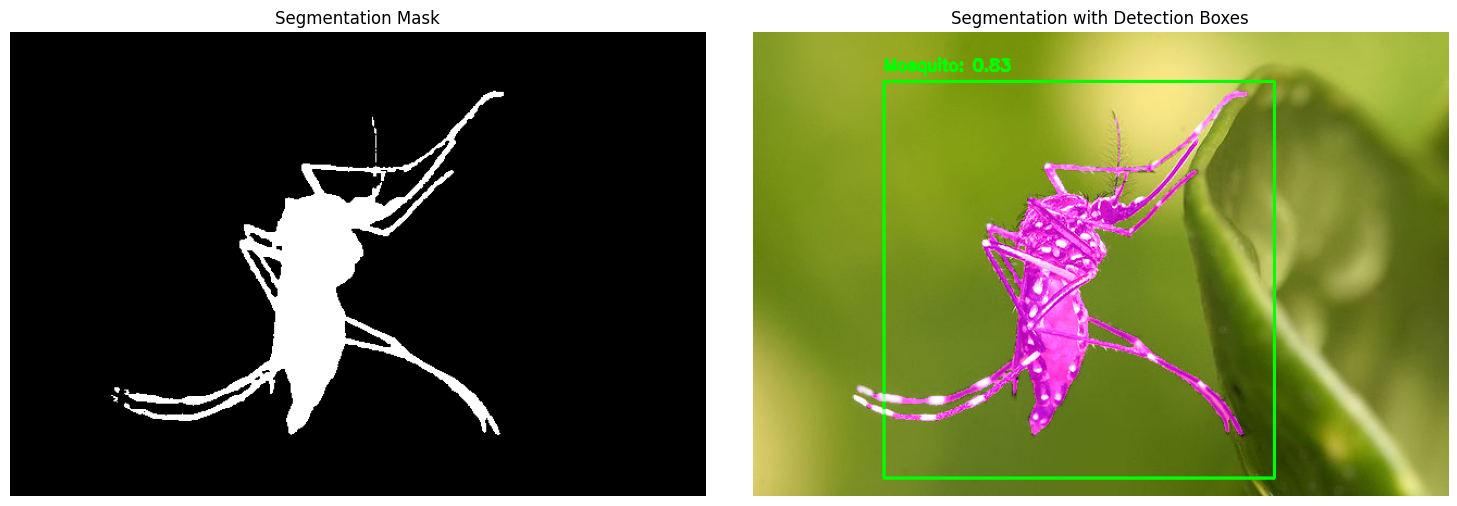

In [6]:
from culicidaelab import MosquitoDetector

# Initialize detector
detector_path = settings.get_model_weights("detection")
detector_config = settings.model_weights_manager.config["models"]["detection"]
detector = MosquitoDetector(model_path=detector_path, config=detector_config)

# Run detection
detections = detector.predict(image)

# Run segmentation with detection boxes
mask_with_boxes = segmenter.predict(image, detection_boxes=detections)
# Draw detections
annotated_image = detector.visualize(image, detections)

# Print detection results
print("\nDetection Results:")
for i, (x, y, w, h, conf) in enumerate(detections):
    print(f"Mosquito {i+1}: Confidence = {conf:.2f}, Box = (x={x:.1f}, y={y:.1f}, w={w:.1f}, h={h:.1f})")
# Visualize results
segmented_image_with_boxes = segmenter.visualize(annotated_image, mask_with_boxes)

# plt.figure(figsize=(10, 10))
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask_with_boxes, cmap="gray")
plt.axis("off")
plt.title("Segmentation Mask")


plt.subplot(1, 2, 2)
plt.imshow(segmented_image_with_boxes)
plt.axis("off")
plt.title("Segmentation with Detection Boxes")

plt.tight_layout()
plt.show()